In [1]:
!pip install biopython torch

In [0]:
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
from Bio import SeqIO
import re

def load_fasta(fname):
  parsed = []
  for seq in SeqIO.parse(fname, "fasta"):
    record = { 'seq': str(seq.seq).upper() }
    if 'trueSeq' in seq.id:
      meta = re.search('::\w+::(?P<rbps>(?:\w+(?:///)?)+)::(?P<id>\w+)', seq.id).groupdict()
      rbps = {key: 1 for key in meta['rbps'].split('///')}
      record['id'] = meta['id']
      record.update(rbps)
    parsed.append(record)
  return pd.DataFrame(parsed).fillna(0)

train = load_fasta('train.txt')
valid = load_fasta('valid.txt')[train.columns]
test = load_fasta('test.txt')[train.columns]

In [4]:
train.head()

,seq,id,ATXN2,FUS,CPSF6,HNRNPC,NUDT21,ELAVL1,LIN28B,FIP1L1,MOV10,WDR33,CPSF7,YTHDF2,CSTF2T,ZC3H7B,CAPRIN1,CPSF1,CPSF4,CPSF3,TARDBP,CSTF2
0,AGCATGTTAGAGTTCTGATGGCAGTTGTTGTTTATGAATAAGCTTC...,ENST00000545308,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AAACATATTCTATTCATTTATTTTATAACTGTTCCCTTGACCTCTT...,ENST00000606457,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CCCCACCCACCCCTTTGGAGAGGTGTCCCTCGTAACATTCTGGAGC...,ENST00000506172,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CTTGCAGTCTGAGCACGCGTAAGGCTTCTCCCCGGTGTGAGCCCGC...,ENST00000492040,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TAATCCACAGTTTCCCAACCTCAGCCCTACTGACACTGGGGCTGGA...,ENST00000572913,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train.tail()

,seq,id,ATXN2,FUS,CPSF6,HNRNPC,NUDT21,ELAVL1,LIN28B,FIP1L1,MOV10,WDR33,CPSF7,YTHDF2,CSTF2T,ZC3H7B,CAPRIN1,CPSF1,CPSF4,CPSF3,TARDBP,CSTF2
194978,TTTTGTTTCCTGTTAATCTTTGTATCTAGGAAAATCTAATCTGCCT...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194979,GCCTTTTATGGGCCACTTGCATTAGTGTCCTGATAGAGGCTTAATC...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194980,GTCTGTCTTCTGTATATACCCTGTAGATCCGAATTTGTGTAAGGAA...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194981,GTTCAGGGTACAGCCAGGTGGGGGAGACAGATCACTATAAAAACCT...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194982,ATGTAGCCAAAATCAGCCAGGAGCGGTGGCTCACCCCTGTAATCCC...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
from collections import Counter
train.seq.apply(Counter).sum()

Counter({'A': 10063517,
         'C': 8246631,
         'G': 8310888,
         'N': 1942403,
         'T': 10433161})

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
all_letters = "ATCG"
n_letters = len(all_letters) + 1
n_categories = len(train.columns) - 2

def seqToTensor(seq):
    tensor = torch.zeros(len(seq), 1, n_letters)
    for li, letter in enumerate(seq):
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

In [9]:
print(seqToTensor('ATCGN'))

tensor([[[1., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0.]],

        [[0., 0., 1., 0., 0.]],

        [[0., 0., 0., 1., 0.]],

        [[0., 0., 0., 0., 1.]]])


In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 64
rnn = RNN(n_letters, n_hidden, n_categories)

In [0]:
criterion = nn.BCELoss()
learning_rate = 0.001

def train_seq(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [12]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []
print_every = 250

for index, row in train.iterrows():
  sequence = seqToTensor(row.seq)
  categories = torch.tensor([row['ATXN2':'CSTF2']])
  output, loss = train_seq(categories, sequence)
  current_loss += loss

  if index % print_every == 0:
    print(index, current_loss / print_every)
    all_losses.append(current_loss / print_every)
    current_loss = 0
  if index > 5000:
    break

0 0.0013425416946411133
250 0.3859780952334404
500 0.38270905655622484
750 0.3762984902858734
1000 0.3809201622009277
1250 0.36144664204120636
1500 0.3674119369387627
1750 0.37873686814308166
2000 0.3694294407963753
2250 0.3667854365706444
2500 0.3545966547131538
2750 0.3581094028949737
3000 0.37191909009218216
3250 0.37061028641462324
3500 0.35078552478551867
3750 0.35914399445056916
4000 0.34089244759082793
4250 0.32666911274194715
4500 0.9543394663929939
4750 1.1745941360592842
5000 1.2357042239308358


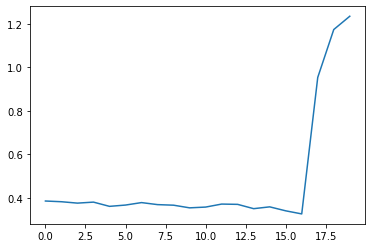

In [13]:
plt.plot(all_losses[1:])

In [0]:
def predict(data, threshold):
  test_true = []
  test_pred = []
  for index, row in data.iterrows():
    sequence = seqToTensor(row.seq)
    categories = torch.tensor([row['ATXN2':'CSTF2']])
    test_true.append(categories.numpy()[0])

    hidden = rnn.initHidden()
    for i in range(sequence.size()[0]):
      output, hidden = rnn(sequence[i], hidden)
    test_pred.append((output > threshold).float().numpy()[0])
  return test_true, test_pred

In [0]:
test_true, test_pred = predict(valid, 0.06)

In [18]:
from sklearn.metrics import classification_report
print(classification_report(test_true, test_pred, target_names=list(test.columns[2:])))

              precision    recall  f1-score   support

       ATXN2       0.23      1.00      0.37       871
         FUS       0.10      0.17      0.13       281
       CPSF6       0.00      0.00      0.00       319
      HNRNPC       0.25      0.23      0.24      1120
      NUDT21       0.00      0.00      0.00       625
      ELAVL1       0.27      0.03      0.06       864
      LIN28B       0.11      0.07      0.09       502
      FIP1L1       0.22      0.05      0.08       682
       MOV10       0.00      0.00      0.00       282
       WDR33       0.00      0.00      0.00       221
       CPSF7       0.00      0.00      0.00       191
      YTHDF2       0.00      0.00      0.00       169
      CSTF2T       0.00      0.00      0.00       359
      ZC3H7B       0.00      0.00      0.00       169
     CAPRIN1       0.00      0.00      0.00       184
       CPSF1       0.00      0.00      0.00       221
       CPSF4       0.00      0.00      0.00       197
       CPSF3       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
